### Plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [205]:
res = pd.read_csv('res.csv')
# res['type'] = res['type'].astype('string')
res[res.iloc[:,2:]>15]=np.nan
res['SSIM'] = 1 - res['SSIM']

In [159]:
res.head()

,lossid,type,MSE_LR,MSE,SSIM,VGG_Loss
0,0,linear,0.023352,0.056637,0.594211,1.352880
1,0,mlp1,0.033770,0.058224,0.571860,1.438981
2,0,mlp2,0.228584,0.060850,0.557190,1.458430
3,0,mlp3,32.944480,0.060376,0.545207,1.557366
4,0,cnn,0.622563,0.061691,0.469250,1.694303


In [206]:
# change one column name
res['type'] = res['type'].replace('linear', 'Single Layer Perceptron')
res['type'] = res['type'].replace('mlp1', 'MLP (1 HL)')
res['type'] = res['type'].replace('mlp2', 'MLP (2 HL)')
res['type'] = res['type'].replace('mlp3', 'MLP (3 HL)')
res['type'] = res['type'].replace('cnn', 'CNN')
res['type'] = res['type'].replace('cnnr', 'Residual CNN')

C:\Users\Amine\AppData\Local\Temp\ipykernel_21392\232139987.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(res['type'][0:6],rotation=45)
C:\Users\Amine\AppData\Local\Temp\ipykernel_21392\232139987.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(res['type'][0:6],rotation=45)
C:\Users\Amine\AppData\Local\Temp\ipykernel_21392\232139987.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(res['type'][0:6],rotation=45)
C:\Users\Amine\AppData\Local\Temp\ipykernel_21392\232139987.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(res['type'][0:6],rotation=45)


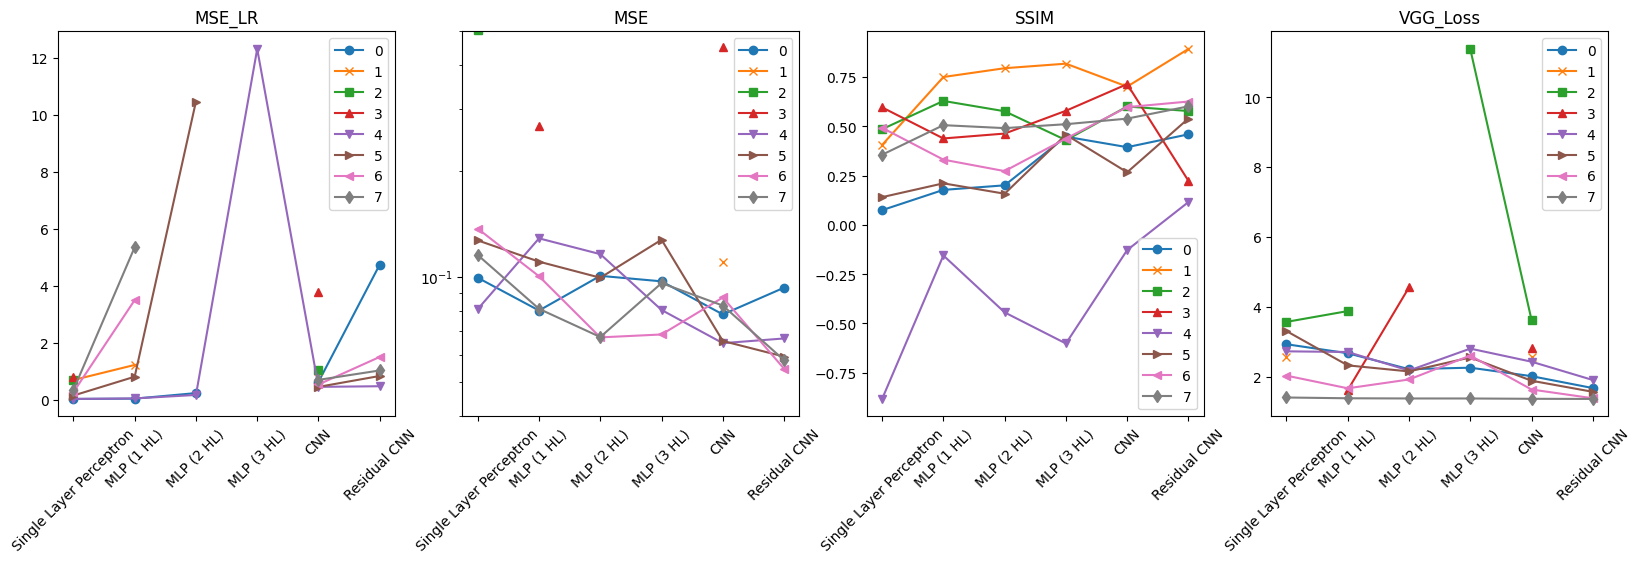

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


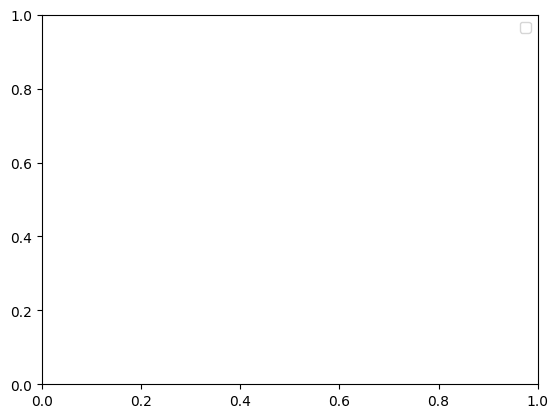

In [207]:
marker=[
    'o',
    'x',
    's',
    '^',
    'v',
    '>',
    '<',
    'd',
]
fig,ax = plt.subplots(1,4,figsize=(20,5))
y_lims = {
    0: (0,0.2),
    1: (0.04, 0.5),
    2: (0,0.5),
    3: (1,2),
}
for i in range(4):
    for j in range(8):
        ax[i].plot(res['type'][j*6:(j+1)*6],res.iloc[j*6:(j+1)*6,i+2],label=res['lossid'][j*6],marker=marker[j])#,s=30)#,color='r')
    
    ax[i].set_title(res.columns[i+2])
    ax[i].legend()  
    # set x ticks rotate 90
    ax[i].set_xticklabels(res['type'][0:6],rotation=45)
    # y_lim
    if i == 1:
        ax[i].set_yscale('log')
        ax[i].set_ylim(y_lims[i])
    # ax[i].set_ylim(y_lims[i])
plt.show()  
plt.legend()
plt.show()


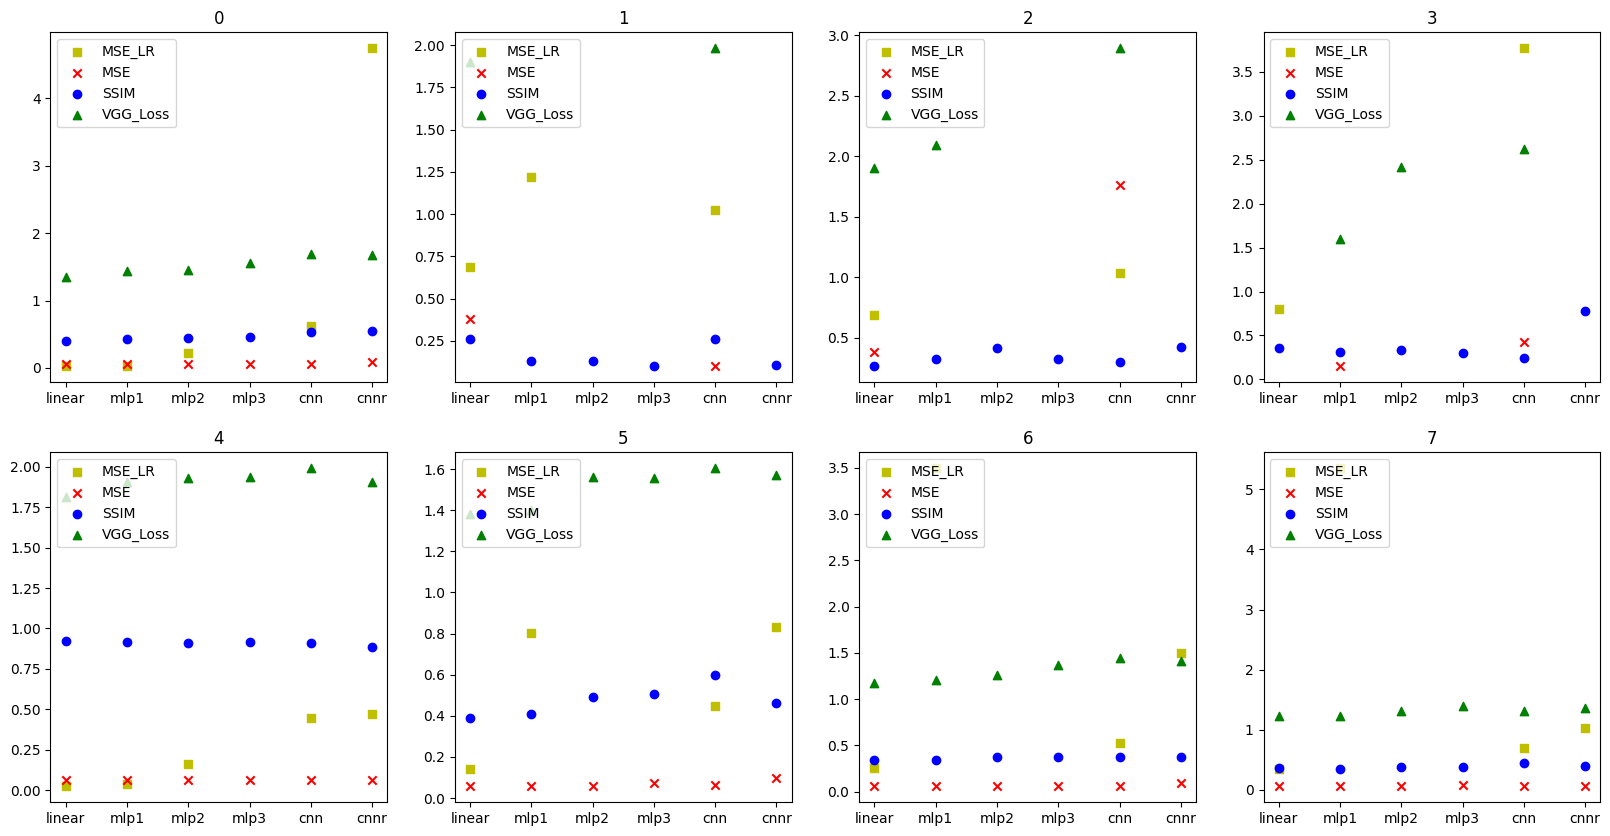

In [84]:
# [0:6]
fig,ax = plt.subplots(2,4,figsize=(20,10))
for i in range(8):

    # ax[i//4,i%4].scatter(res['type'][i*6:(i+1)*6],res['MSE_LR'][i*6:(i+1)*6],label='MSE_LR',marker=',',color='y')
    ax[i//4,i%4].scatter(res['type'][i*6:(i+1)*6],res['MSE'][i*6:(i+1)*6],label='MSE',marker='x',color='r')
    # ax[i//4,i%4].scatter(res['type'][i*6:(i+1)*6],res['SSIM'][i*6:(i+1)*6],label='SSIM',marker='o',color='b')
    # ax[i//4,i%4].scatter(res['type'][i*6:(i+1)*6],res['VGG_Loss'][i*6:(i+1)*6],label='VGG_Loss',marker='^',color='g')
    ax[i//4,i%4].legend(loc='upper left')
    ax[i//4,i%4].set_title(i)
plt.show()

In [60]:
alpha01 = pd.read_csv('alpha.01.csv',index_col=0)
alpha = pd.read_csv('alpha.csv',index_col=0)

,Val Epoch Loss,Training Last MSE,Test Epoch Loss01,Test Epoch MSE01,Test Epoch SSIM`01,Test Last MSE
TASK: ALPHA EXPLORATION,,,,,,
0.00,0.041487,0.004964,0.041329,0.066145,0.413285,0.203406
0.01,0.041749,0.004966,0.041571,0.066142,0.413233,0.203406
0.02,0.042076,0.004974,0.041873,0.066136,0.413774,0.203444
0.03,0.042340,0.004971,0.042120,0.066124,0.413781,0.203393
0.04,0.042555,0.004958,0.042323,0.066131,0.413308,0.203434


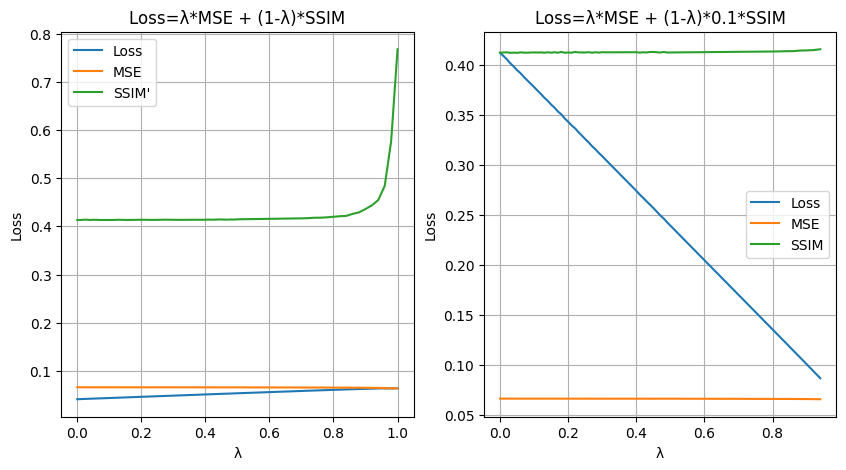

In [72]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Loss=\u03BB*MSE + (1-\u03BB)*SSIM')
ax[0].plot(alpha01.index,alpha01['Test Epoch Loss01'],label="Loss")
ax[0].plot(alpha01.index,alpha01['Test Epoch MSE01'],label="MSE")
ax[0].plot(alpha01.index,alpha01['Test Epoch SSIM`01'],label="SSIM'")
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('\u03BB')
ax[0].set_ylabel('Loss')
ax[1].set_title('Loss=\u03BB*MSE + (1-\u03BB)*0.1*SSIM')
ax[1].plot(alpha.index,alpha['Test Epoch Loss'],label="Loss")
ax[1].plot(alpha.index,alpha['Test Epoch MSE'],label="MSE")
ax[1].plot(alpha.index,alpha['Test Epoch SSIM`'],label="SSIM")
ax[1].set_ylabel('Loss')
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('\u03BB')
# plt.yscale('log')
# plt.yticks(np.arange(0,0.1,0.01))
plt.show()


### Logs Scrapper

In [ ]:
def get_test(file_path):
    tests = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.find("Avg Test Loss: ") != -1:
                tests.append(line.strip())
    return tests
tests = get_test('t.txt')
for test in tests:
    splitted = test.split(' ')
    print(f"{str(splitted[3])[:10]}\t{str(splitted[7])[:10]}\t{str(splitted[11])[:10]}\t{str(splitted[-1])[:10]}")
    # print(test)

In [ ]:
def process_u(file_path:str):
    records = []
    prev = None
    this = None
    with open(file_path, 'r') as f:
        for i,line in enumerate(f):
            if i == 0:
                this = line
                continue
            prev = this
            this = line
            found = this.find("@ 0...") != -1
            if found:
                prev = prev.strip().split(" ")[:2]
                records.append((prev[0],prev[1]))
            # record = line.split()
            # records.append(record)
    return records
for x in process_u("./u.txt")[1:]:
    print(f"{x[0]}\t{x[1]}")

In [ ]:
def process_text_file(file_path):
    records = []
    with open(file_path, 'r') as file:
        epoch_line = None
        iteration_config = None
        
        for line in file:
            # print(line)
            # break
            if line.startswith("Best state dict yet, with "):
                epoch_line = line.strip()
                
            # Check if both epoch_line and iteration_config are set
            if epoch_line:# and iteration_config:
                records.append(epoch_line)
                epoch_line = None
                # iteration_config = None
    return records

# Example usage:
file_path = "./t.txt"
result = process_text_file(file_path)

for resul in result:
    print(resul)

### Evaluation

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import pandas as pd
import torch.nn.functional as F
from torchmetrics.image import StructuralSimilarityIndexMeasure
from utils.classes import *
# from skimage.metrics import structural_similarity as ssim
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 64
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)
np.random.seed(seed=seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


ssim = StructuralSimilarityIndexMeasure(reduction='elementwise_mean').to(device)

batch_size = 128

In [103]:
DIFFS_IMGS_TRAIN_PATH = "./data/eit/diffs_imgs_train.csv"
DIFFS_IMGS_TEST_PATH = "./data/eit/diffs_imgs_test.csv"

diff_transform = transforms.Compose([transforms.ToTensor()])
img_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = DiffImg(csv_file=DIFFS_IMGS_TRAIN_PATH, diff_transform=diff_transform, img_transform=img_transform,npf=False,ppf=False)
test_dataset = DiffImg(csv_file=DIFFS_IMGS_TEST_PATH, diff_transform=diff_transform, img_transform=img_transform,npf=False,ppf=False)

generator = torch.Generator().manual_seed(seed)
train_size = int(0.8 * len(train_dataset)) 
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
ppf=0
npf=0
for i, (d,im) in tqdm(enumerate(train_dataloader)):
    # print(_.shape)
    # break
    npf += torch.sum(torch.min(im.reshape(batch_size, -1), dim=1)[0] == 0.0).item()
    ppf += torch.sum(torch.min(im.reshape(batch_size, -1), dim=1)[0] != 0.0).item()
print(ppf, npf)
for i, (d,im) in tqdm(enumerate(val_dataloader)):
    # print(_.shape)
    # break
    npf += torch.sum(torch.min(im.reshape(batch_size, -1), dim=1)[0] == 0.0).item()
    ppf += torch.sum(torch.min(im.reshape(batch_size, -1), dim=1)[0] != 0.0).item()
print(ppf, npf)
for i, (d,im) in tqdm(enumerate(test_dataloader)):
    # print(_.shape)
    # break
    npf += torch.sum(torch.min(im.reshape(batch_size, -1), dim=1)[0] == 0.0).item()
    ppf += torch.sum(torch.min(im.reshape(batch_size, -1), dim=1)[0] != 0.0).item()
print(ppf, npf)

150it [00:01, 92.47it/s]


7009 12191


38it [00:00, 95.81it/s]


8750 15314


47it [00:00, 103.34it/s]

10949 19131


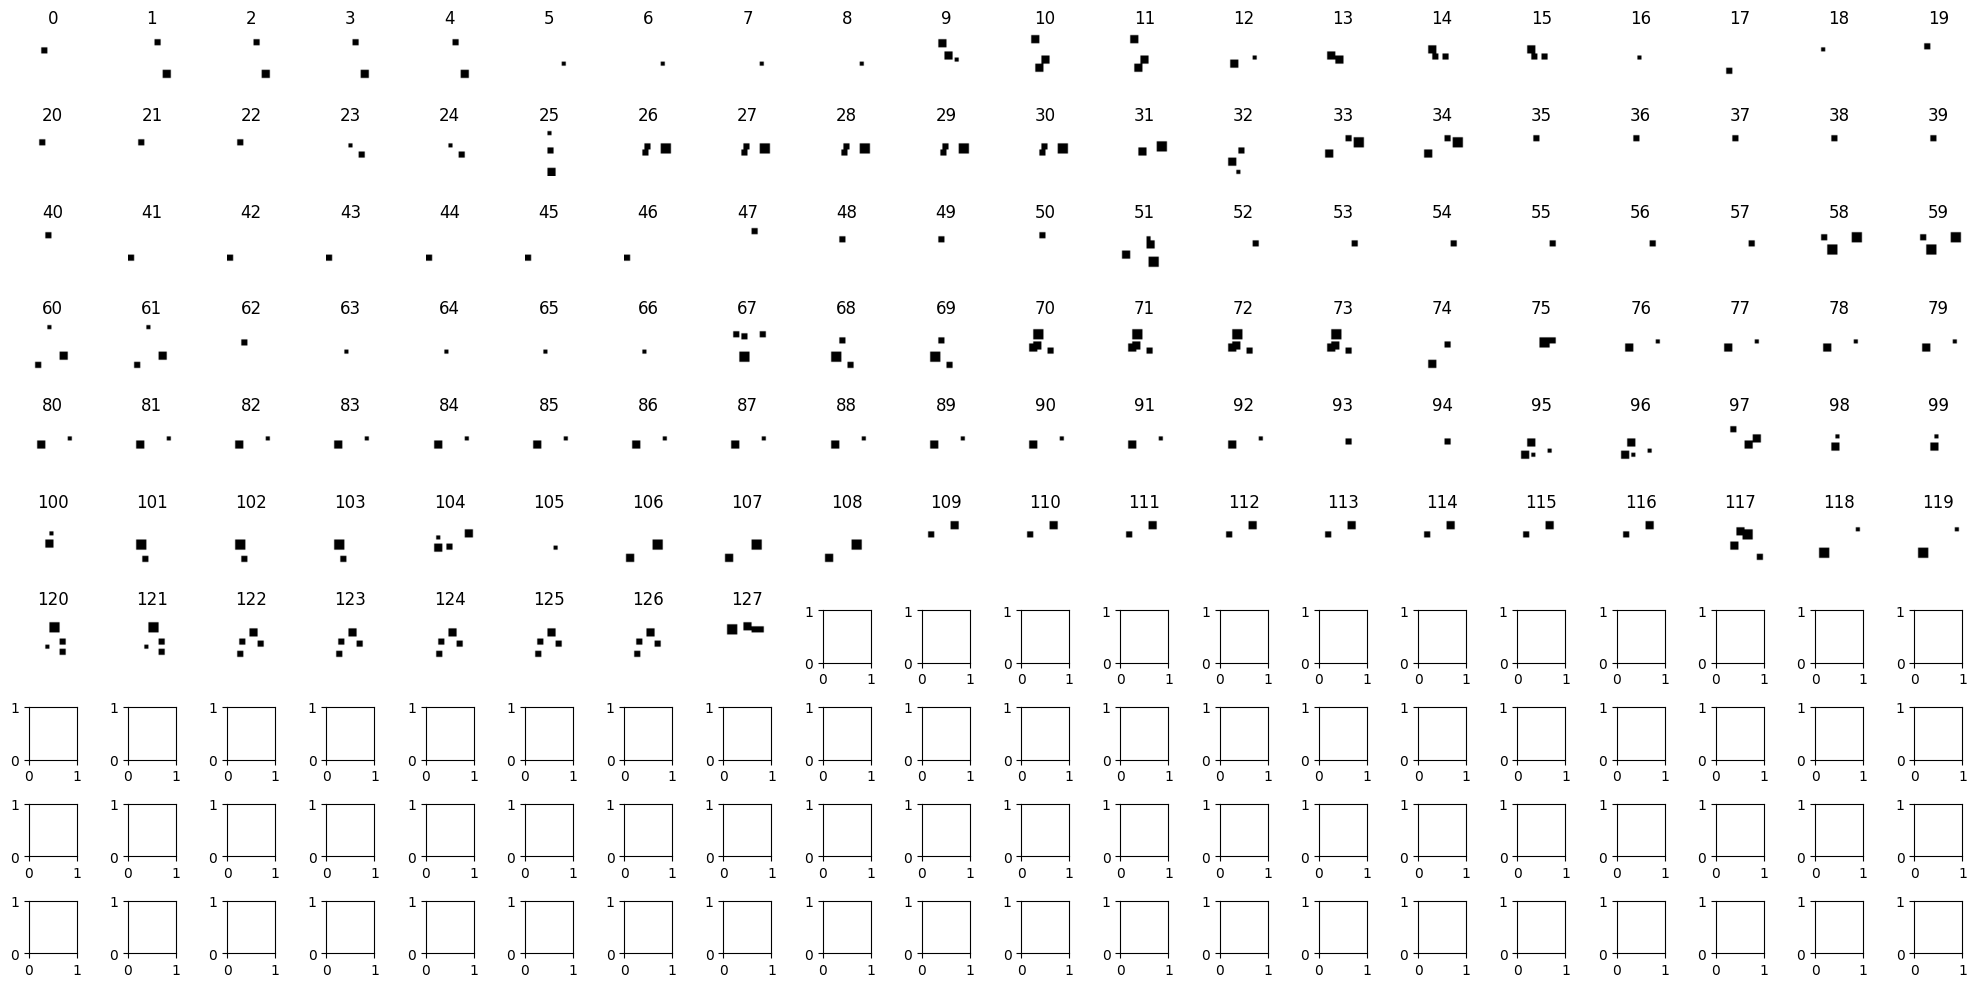

In [97]:
fig,ax = plt.subplots(10,20,figsize=(20,10))
for i, (_, imgs) in enumerate(test_dataloader):
    for j,img in enumerate(imgs):
        ax[j//20,j%20].imshow(img[0],cmap='gray')
        ax[j//20,j%20].axis('off')
        ax[j//20,j%20].set_title(f"{i*batch_size+j}")
    break
plt.tight_layout()
plt.show()

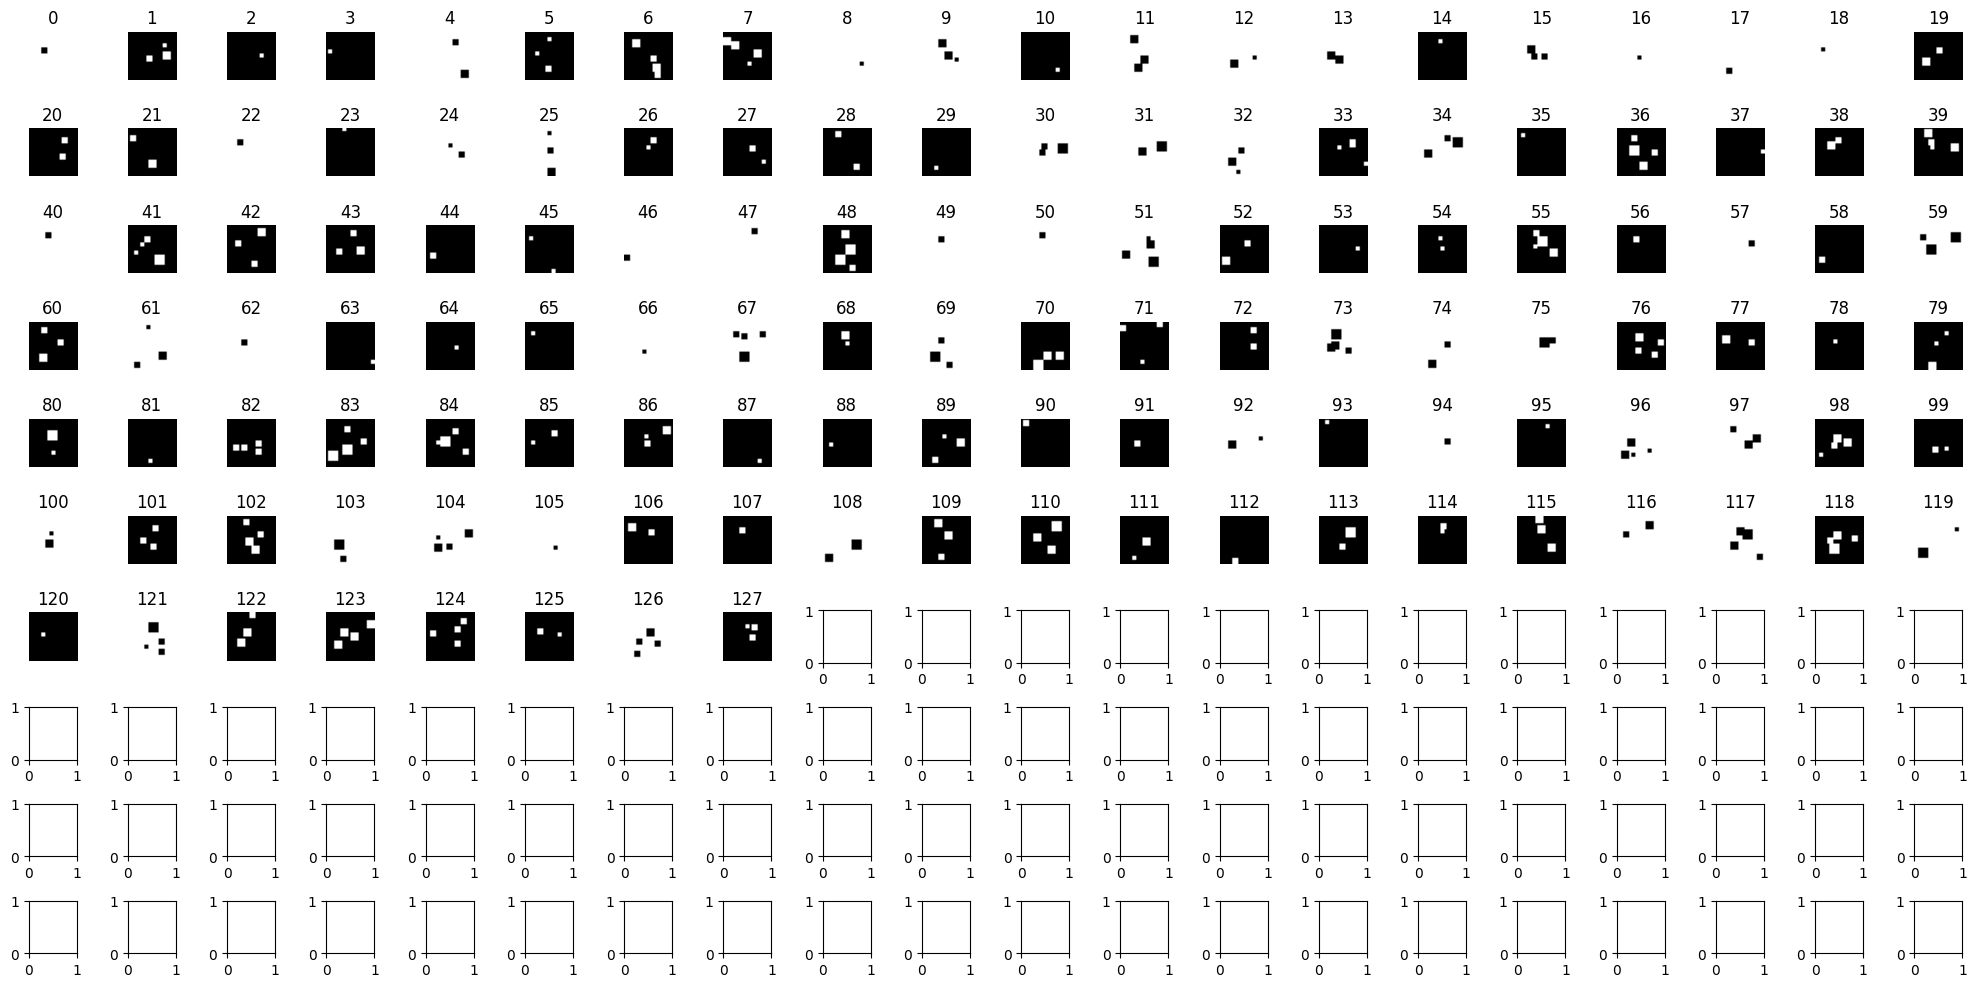

In [104]:
fig,ax = plt.subplots(10,20,figsize=(20,10))
for i, (_, imgs) in enumerate(test_dataloader):
    for j,img in enumerate(imgs):
        ax[j//20,j%20].imshow(img[0],cmap='gray')
        ax[j//20,j%20].axis('off')
        ax[j//20,j%20].set_title(f"{i*batch_size+j}")
    break
plt.tight_layout()
plt.show()

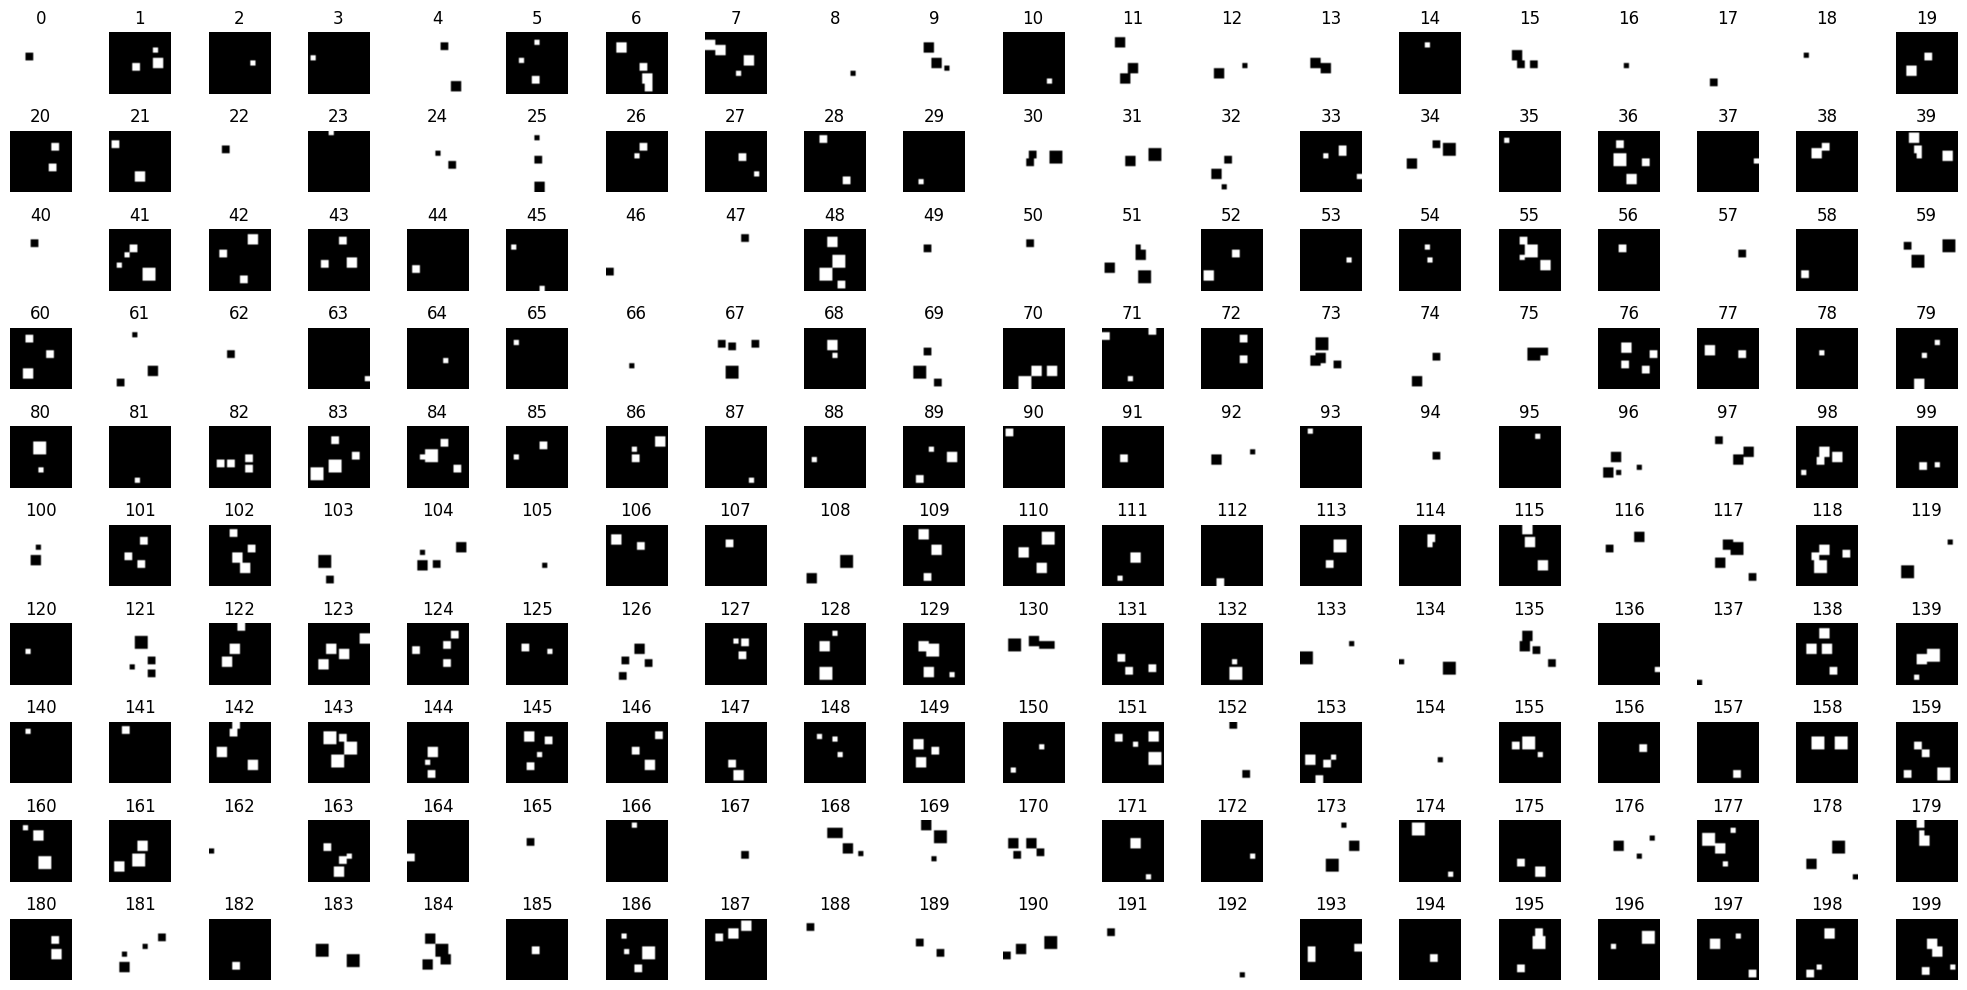

In [10]:
fig,ax = plt.subplots(10,20,figsize=(20,10))
for i, (_, imgs) in enumerate(test_dataloader):
    for j,img in enumerate(imgs):
        ax[j//20,j%20].imshow(img[0],cmap='gray')
        ax[j//20,j%20].axis('off')
        ax[j//20,j%20].set_title(f"{i*batch_size+j}")
    break
plt.tight_layout()
plt.show()

In [30]:
def adjusted_mse(batch_img, batch_recon):
    mask = (batch_img != 0.0).float()
    num_valid_pixels = torch.sum(mask)
    squared_diff = (batch_img - batch_recon).to(device)**2 * mask.to(device)
    mse = torch.sum(squared_diff) / (num_valid_pixels)
    return mse

In [28]:
# def compute_mse_aoi(recons,preds):
#     mses_aoi = torch.tensor(0.0, device=device)
#     for recon,pred in zip(recons,preds):
#         vals,counts = recon.unique(return_counts=True)

#         foreground_value = vals[counts.argmin()]
#         aoi = (recon == foreground_value).nonzero()
#         xmin=aoi[:,1].min()
#         xmax=aoi[:,1].max()
#         ymin=aoi[:,2].min()
#         ymax=aoi[:,2].max()
#         recon_aoi = recon[:, xmin:xmax + 1, ymin:ymax + 1]
#         pred_aoi = pred[:, xmin:xmax + 1, ymin:ymax + 1]

#         mse_aoi=F.mse_loss(recon_aoi, pred_aoi)
#         mses_aoi += mse_aoi

#     mse_aoi = mses_aoi/len(recons)
#     return mse_aoi

criterion = VGGPerceptualLoss().to(device)
def play(lossid=0,r=0,dataloader:DataLoader=None,
         tracker:LossTracker=None,
         v2lr:nn.Module=None,
         ssim=None,optimizer=None):
    
    v2lr.train() if tracker.job=="Training" else v2lr.eval()

    for i, (batch_diff, batch_img) in enumerate(dataloader):
        batch_diff = batch_diff.to(device)
        batch_img = batch_img.to(device)
        if i == r:
            batch_diff = batch_diff.to(device)
        batch_img = batch_img.to(device)
        batch_mapped, batch_lr, batch_recon_v = v2lr(batch_diff,batch_img)

        # scale_to_input removed from here
        mse_loss = F.mse_loss(batch_img, batch_recon_v)
        ssim_value = 1 - ssim(batch_img, batch_recon_v) 
        vgg_loss = criterion(batch_img,batch_recon_v)
        mse_loss_lr = F.mse_loss(batch_lr, batch_mapped)
        
        # 0 MSE
        if lossid==0:
            loss = mse_loss
        # 1 SSIM
        elif lossid==1:
            loss=ssim_value
        # 2 alpha*mse + (1-alpha)*ssim
        elif lossid==2:
            alpha=0.05
            loss = alpha*mse_loss + (1-alpha)*ssim_value
        # 3 alpha*mse + (1-alpha)*0.1*ssim
        elif lossid==3:
            alpha=0.1
            loss = alpha*mse_loss + (1-alpha)*0.1*ssim_value
        # 4 mse/ssim+1
        elif lossid==4:
            loss=mse_loss/(ssim_value+1)
        # 5 mse_aoi
        elif lossid==5:
            loss = adjusted_mse(batch_img,batch_recon_v)
        # 6 vgg_loss
        elif lossid==6:
            loss=vgg_loss
        # 7 vgg_loss+10*mse_aoi
        elif lossid==7:
            loss=vgg_loss+10*adjusted_mse(batch_img,batch_recon_v) 
        
        if tracker.job == "Training":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # if i == r:
        d,b,r = batch_diff,batch_img,batch_recon_v
        break

    tracker.epoch_mse_loss = mse_loss
    tracker.epoch_ssim = ssim_value
    tracker.epoch_loss = loss
    tracker.epoch_loss_lr = mse_loss_lr

    # epoch rebackprog removed from here
    return d, b, r, tracker

c:\Users\Amine\.conda\envs\eit\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Amine\.conda\envs\eit\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [119]:
a=torch.load("./models/img/14.2.1.retraining.2.20231130014311_img.pt").to(device)
a

AutoencoderEIT(
  (encoder): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 96, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(192, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(24, 3, 3))
    (1): ConvTranspose2d(24, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ConvTranspose2d(192, 96, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(96, 48, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(48, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [127]:
a.encoder[0](torch.rand(3,1,24,24).to(device)).shape

torch.Size([3, 48, 12, 12])

In [132]:
v2lr.recon.decoder

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(24, 3, 3))
  (1): ResidualBlockk(
    (conv1): ConvTranspose2d(24, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (skip): ConvTranspose2d(24, 192, kernel_size=(1, 1), stride=(1, 1))
  )
  (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ResidualBlockk(
    (conv1): ConvTranspose2d(192, 96, kernel_size=(3, 3), stride=(1, 1))
    (conv2): ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (skip): ConvTranspose2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  )
  (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ResidualBlockk(
    (conv1): ConvTranspose2d(96, 48, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (conv2): ConvTranspose2d(48, 48, kernel_size=(

In [130]:
v2lr = torch.load("./models/v2lr/1.5.vgg.b4.20231223165118_v2lr.pt").to(device) #1.5.vgg.b4.20231223165118_v2lr.pt
v2lr.v2lr

Sequential(
  (0): ResidualBlock(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (skip): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ResidualBlock(
    (conv1): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (skip): Conv2d(6, 18, kernel_size=(1, 1), stride=(1, 1))
  )
  (3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ResidualBlock(
    (conv1): Conv2d(18, 54, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(54, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (skip): Conv2d(18, 54, kernel_size=(1, 1), stride=(1, 1))
  )
  (5): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [108]:
tester = LossTracker(job="Testing")
ssim = StructuralSimilarityIndexMeasure(reduction='elementwise_mean').to(device)

mses = {} #torch.zeros(batch_size, device=device)
with torch.no_grad():
    for i in tqdm(range(1)):
        batch_diff,batch_img,batch_recon,tester = play(7,i,test_dataloader,tester,v2lr,ssim)
        for j in tqdm(range(batch_size)):
            if j in [2,19,1,36]:#[2,19,1,102,0,4,69,126]:
                a=F.mse_loss(batch_img[j], batch_recon[j],reduction='none').mean(dim=(0,1,2))
                mses[i*batch_size+j] = {'mse':a.item(),
                                        'ssim':ssim(batch_img[j].unsqueeze(0), batch_recon[j].unsqueeze(0)).item(),
                                        # 'adj_mse':adjusted_mse(batch_img[j], batch_recon[j]).item(),
                                        'vggloss':criterion(batch_img[j], batch_recon[j]).item(),
                                        'batch_img':batch_img[j],
                                        'batch_recon':batch_recon[j],
                                        }

100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


In [26]:
# mses.items() change it to list
# sorted_mses = list(mses.items())
# sorted_mses = sorted(mses.items(), key=lambda x: x[1]['mse'])
# a=[stuff[1]['mse'] for stuff in sorted_mses]

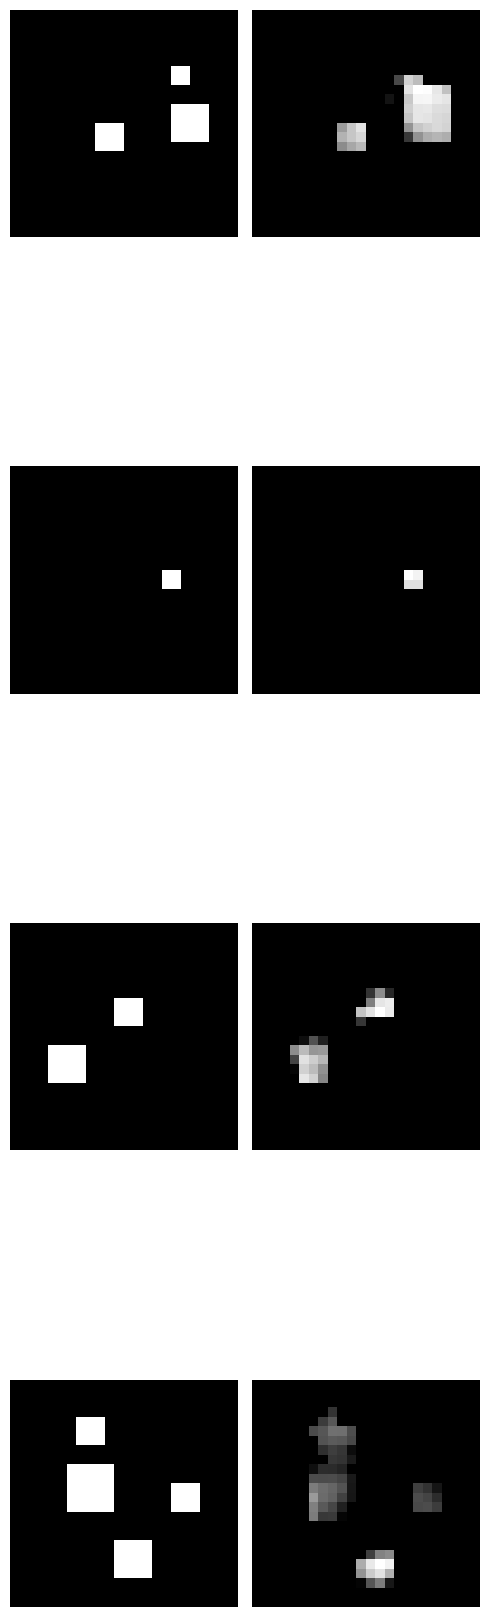

In [113]:
fig,ax = plt.subplots(4,2,figsize=(5,20))
# for i,stuff in enumerate(sorted_mses[:0]+sorted_mses[-20:]):

for i,stuff in enumerate(mses.items()):
    ax[i,0].imshow(stuff[1]['batch_img'].squeeze().cpu().numpy(),cmap='gray')
    ax[i,0].axis('off')
    # ax[i]2].set_title(f"{stuff[1]['mse']:.4f} {stuff[1]['ssim']:.4f} {stuff[1]['vggloss']:.4f}")
    ax[i,1].imshow(stuff[1]['batch_recon'].squeeze().cpu().numpy(),cmap='gray')
    ax[i,1].axis('off')
    # ax[i//4, i%4*2+1].set_title(f"MSE: {stuff[1]['mse']:.4f} SSIM:{stuff[1]['ssim']:.4f} VGGLoss:{stuff[1]['vggloss']:.4f}")

    # a vertical seperator line
    # ax[i//10, i%10*2].axvline(x=0, ymin=0, ymax=1, color='r', linestyle='-',linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
_=plt.plot(a,np.arange(1, len(a) + 1) / len(a))
_=plt.axvline(x=0.01, color='r', linestyle='--')
_=plt.grid()
# _=plt.xticks([0,0.25,0.5,1])
_=plt.xscale('log')
plt.show()

In [ ]:
"""
IMAGE RECONSTRUCTION: evaluator
"""
alpha = 0.3
beta = 0.7 
recon.eval()

with torch.no_grad():
    for i, (batch_diff, batch_img) in tqdm(enumerate(val_dataloader)):
        batch_diff = batch_diff.to(device)
        batch_img = batch_img.to(device)

        batch_mapped = v2lr(batch_diff)
        batch_recon = recon.decoder(batch_mapped)

        mse_loss = F.mse_loss(batch_recon, batch_img)
        batch_recon = batch_recon.squeeze().cpu().detach().numpy()
        batch_img = batch_img.squeeze().cpu().detach().numpy()
        ssim_value = 1 - ssim(batch_recon, batch_img,
                            data_range=max(batch_recon.max(), batch_img.max()) - min(batch_img.min(), batch_recon.min()),
                            win_size=3)

        # Combined weighted loss
        loss = alpha * mse_loss + beta * ssim_value
        print(mse_loss.item(), ssim_value.item(), loss.item())
        if i == 10:
            break

In [ ]:
recon_path = "./models/img/14.2.2.20231210034221_img.pt"
recon_model = torch.load(recon_path)

In [ ]:
def play_recon(r,dataloader:DataLoader=None,
         tracker:LossTracker=None,
         recon:nn.Module=None,
         ssim=None,optimizer=None):    

    recon.train()  if tracker.job=="Training" else recon.eval()
    
    for i, (batch_diff, batch_img) in enumerate(dataloader):
        batch_diff = batch_diff.to(device)
        batch_img = batch_img.to(device)
        _,batch_decoded = recon(batch_img)
        
        # scale_to_input removed from here
            
        mse_loss = F.mse_loss(batch_img, batch_decoded)
        ssim_value = 1 - ssim(batch_img, batch_decoded) 
        mse_aoi = compute_mse_aoi(batch_img,batch_decoded)
        loss = mse_aoi
     
        if tracker.job == "Training": # batch
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tracker.epoch_mse_loss += mse_loss.item()
        tracker.epoch_ssim += ssim_value.item()
        tracker.epoch_loss += loss.item()

        if i == r:
            d,b,r = batch_diff,batch_img,batch_decoded
            break

    tracker.epoch_mse_loss /= (i+1)
    tracker.epoch_ssim /= (i+1)
    tracker.epoch_loss /= (i+1)

    # epoch rebackprog removed from here
    return d,b,r,tracker

In [ ]:
tester = LossTracker(job="Testing")
ssim=StructuralSimilarityIndexMeasure(reduction='elementwise_mean').to(device)
with torch.no_grad():
    batch_diff,batch_img,batch_recon,tester = play_recon(2,test_dataloader,tester,recon_model,ssim)
    print(tester)

In [34]:
batch_diff=batch_diff.cpu().numpy()
batch_img=batch_img.cpu().numpy()
batch_recon=batch_recon.cpu().numpy()

In [ ]:
cols = 4
b=3
fig, ax = plt.subplots(2, cols*b, figsize=(30, 10))  # Create a larger subplot for all three sets
plt.subplots_adjust(wspace=0, hspace=0)

for i, (diff, img, recon) in enumerate(zip(batch_diff,batch_img, batch_recon)):
    # Plot the diff image
    m = np.min((img, recon))
    M = np.max((img, recon))
    ax[i // cols, i % cols * b].imshow(diff.reshape(16,16), cmap='gray') # other that gray
    ax[i // cols, i % cols * b].axis('off')

    # Plot the original image
    ax[i // cols, i % cols * b+1].imshow(img.reshape(24,24), cmap='gray')
    ax[i // cols, i % cols * b+1].axis('off')
    # ax[i // cols, i % cols * 2].set_title('Original')

    # Plot the reconstructed image
    ax[i // cols, i % cols * b + 2].imshow(recon.reshape(24,24), cmap='gray')
    ax[i // cols, i % cols * b + 2].axis('off')
    # ax[i // cols, i % cols * 2 + 1].set_title('Reconstructed')

# tight plot
plt.tight_layout()
plt.show()

In [87]:
# create a forward function for the ModuleDict
def forward(blocks, x):
    x = x.repeat(3,1,1)
    for block in blocks:
        x = block(x)
    return x.detach().cpu().numpy()


img_features = forward(criterion.blocks[0], batch_img[2])
recon_features = forward(criterion.blocks[0], batch_recon[2])
img_features.shape
rows,cols,b = 8,8,2
fig,ax = plt.subplots(rows,cols*b,figsize=(40,20))
for i,(img_feature,recon_feature) in enumerate(zip(img_features,recon_features)):
    ax[i // rows, i % cols * b].imshow(img_feature,cmap='gray')
    ax[i // rows, i % cols * b].axis('off')
    
    ax[i // rows, i % cols*b + 1].imshow(recon_feature,cmap='gray')
    ax[i // rows, i % cols*b + 1].axis('off')

plt.tight_layout()
plt.show()

In [88]:
s = 0
for i in range(batch_size):
    # print(np.mean(np.square(batch_img[i] - batch_recon[i])))
    # s+=np.mean(np.square(batch_img[i] - batch_recon[i]))
    adj = adjusted_mse(torch.Tensor(batch_img[i]), torch.Tensor(batch_recon[i])).item()
    mse = F.mse_loss(torch.Tensor(batch_img[i]), torch.Tensor(batch_recon[i])).item()
    print(f"{i}  {adj:.5f}  {mse:.5f}")

0  1.88346  0.01311
1  1.88346  0.01311
2  1.88346  0.01311
3  0.01500  0.00014
4  0.01500  0.00014
5  0.01500  0.00014
6  0.01500  0.00014
7  0.07719  0.00353


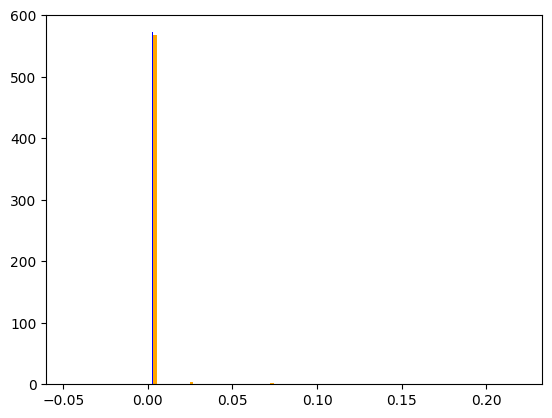

In [45]:
_=plt.hist(batch_recon[0].reshape(-1),bins=100, color='orange')
_=plt.hist(batch_img[0].reshape(-1),bins=100, color='blue')
# _=plt.xticks(np.arange(-1, 0.5, step=0.01)) 
plt.show()